# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [1]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/zakariaabou/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import gen_dr, gen_d, gen_ex2, gen_dr_train,gen_dr_test, voir_batch2D, UNet, make_batch

Cloning into 'exam_2025_session2'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 85 (delta 25), reused 8 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (85/85), 313.40 KiB | 28.49 MiB/s, done.
Resolving deltas: 100% (25/25), done.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


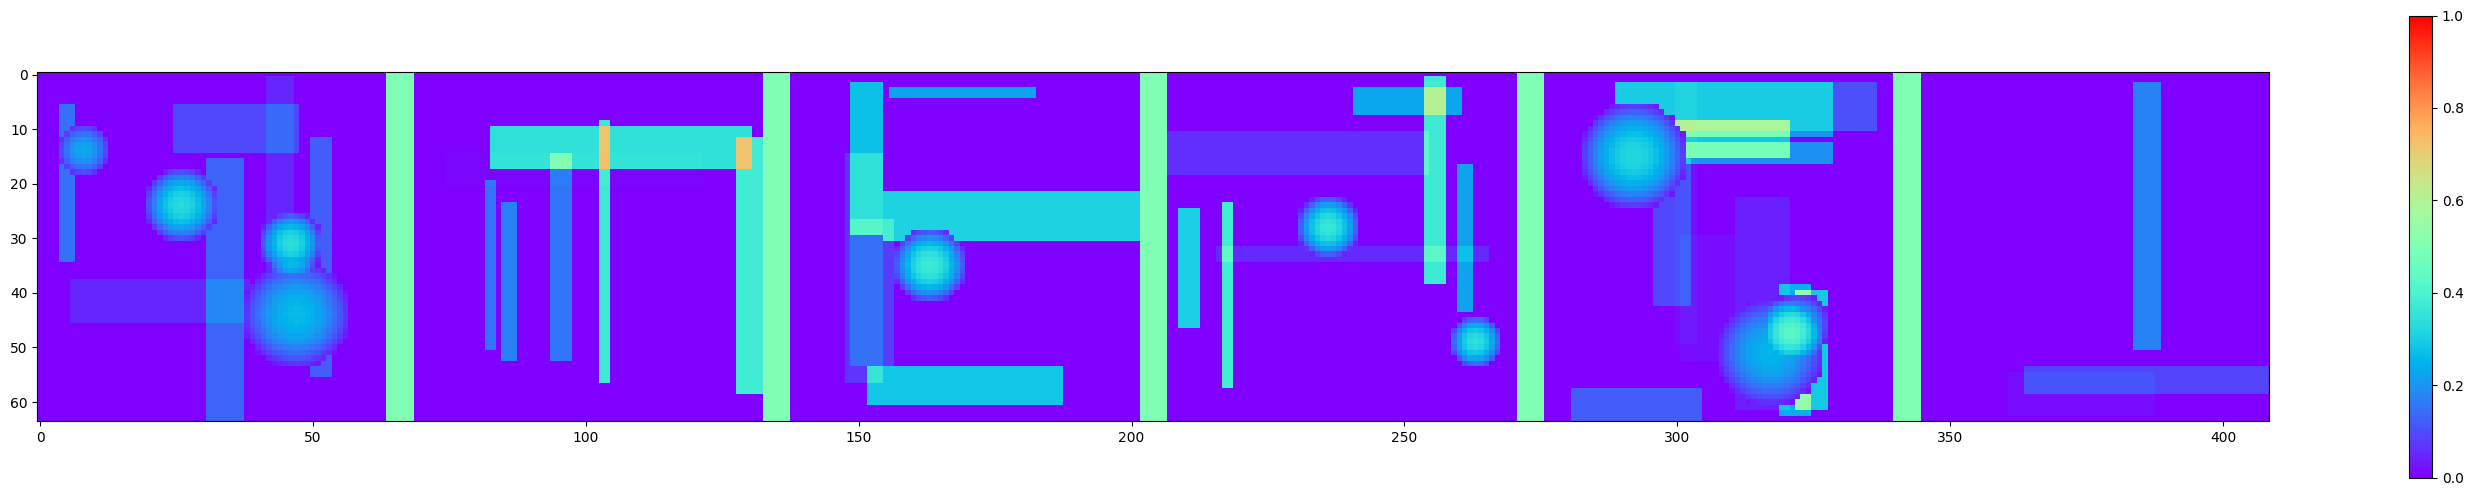

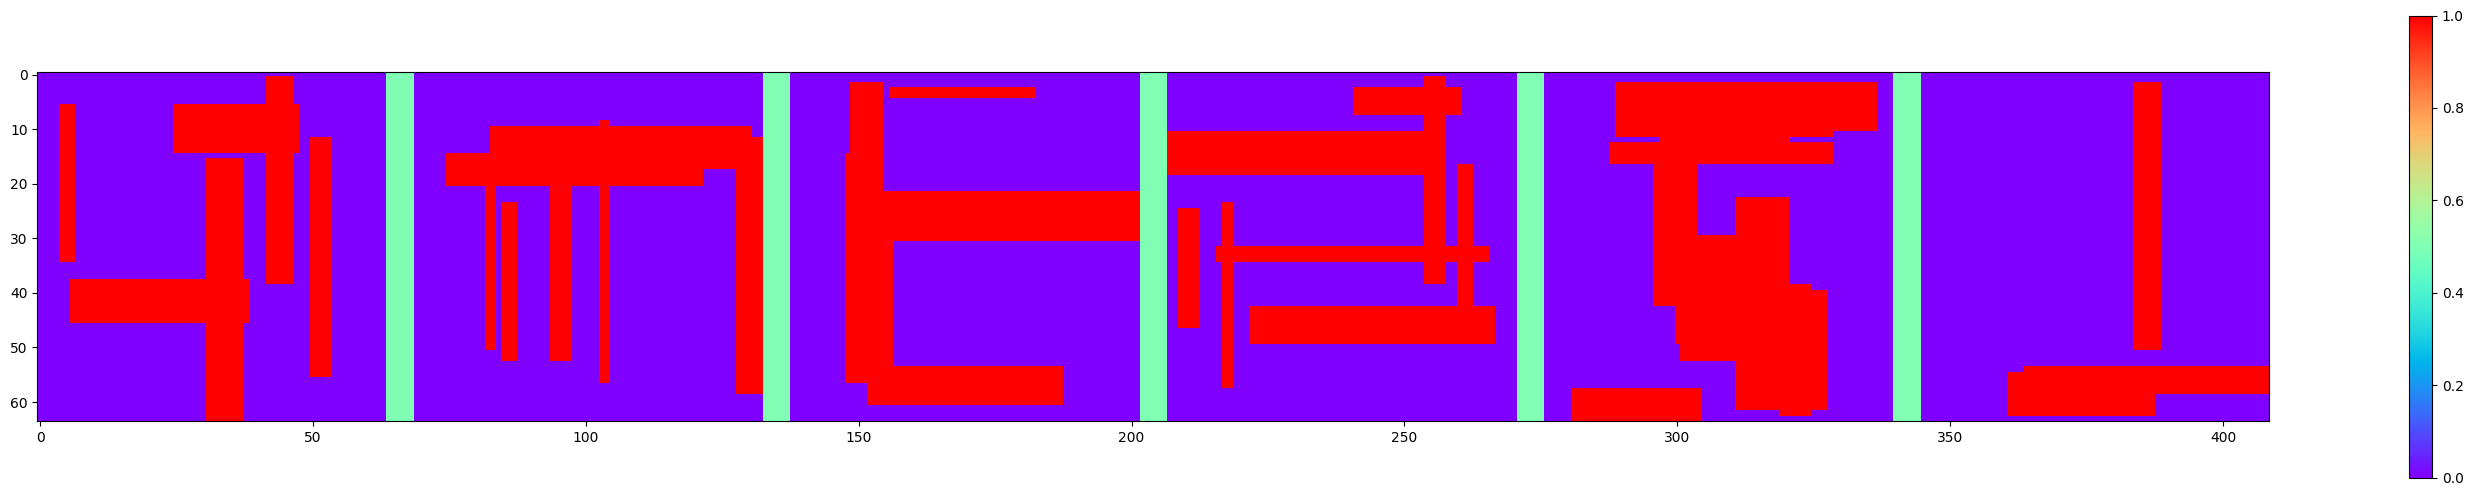

In [2]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

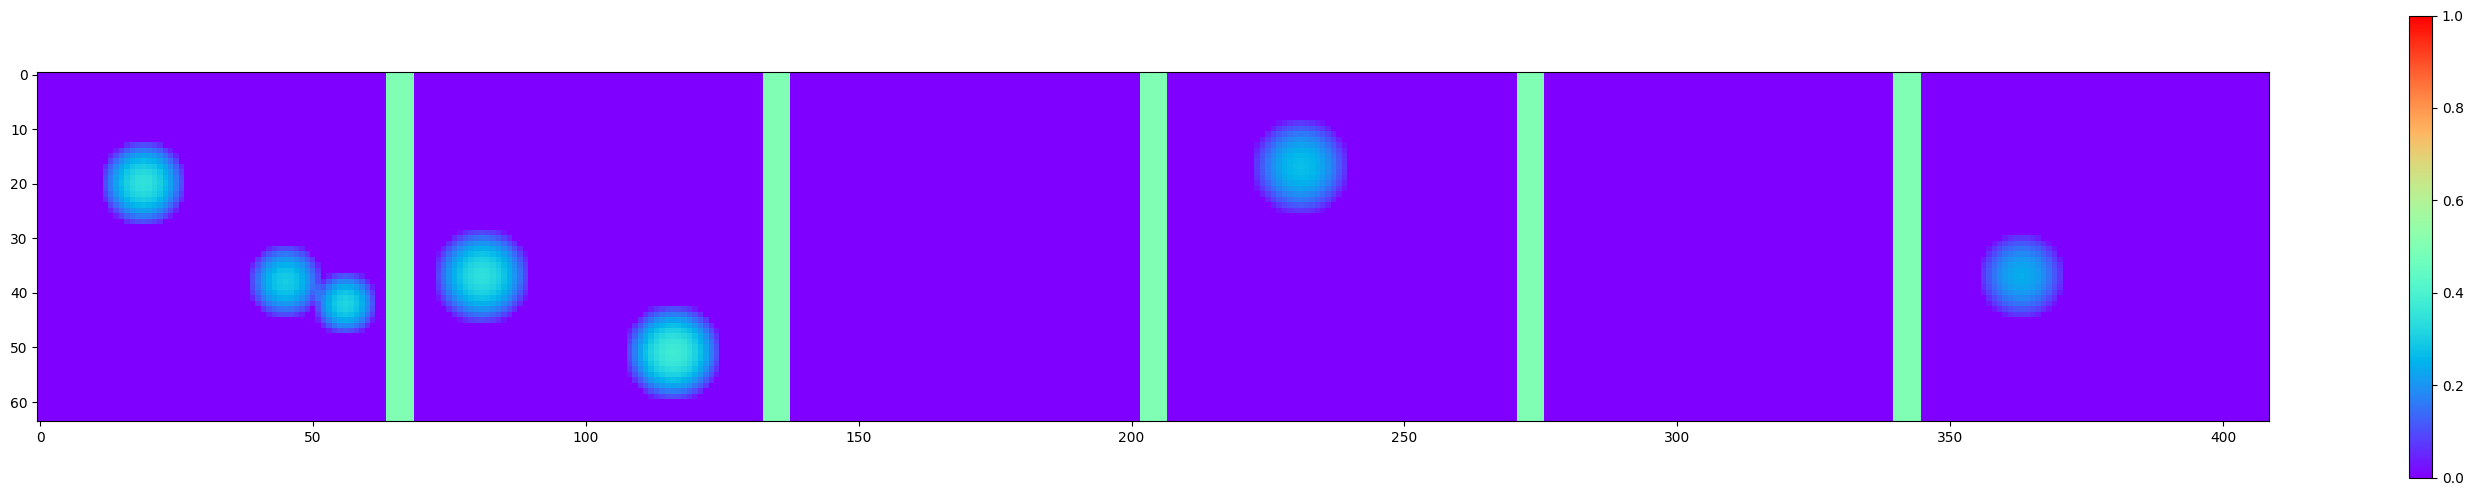

In [3]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?

La supervision faible consiste à apprendre à partir de données partiellement étiquetées, bruitées ou imprécises. Dans cet exercice, la segmentation doit être effectuée sur des images corrompues (avec des disques ajoutés comme bruit), sans disposer d'une cible idéale précise. Cela correspond à un cas de supervision faible, car la cible idéale (sans bruit) n'est pas disponible, et le modèle doit apprendre à partir des données corrompues.

**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

In [7]:
# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Generate training and testing data
train_input, train_targets = gen_dr_train(1000)
test_input, test_targets = gen_dr_test(100)

# Create UNet model
model = UNet()

# Define loss function and optimizer
criterion = torch.nn.MSELoss() # Using Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Training loop
for epoch in range(EPOCHS):
  # Convert to tensors
  inputs = torch.tensor(train_input, dtype=torch.float32)
  targets = torch.tensor(train_targets, dtype=torch.float32)

  # Zero gradients
  optimizer.zero_grad()

  # Forward pass
  outputs = model(inputs)

  # Calculate loss
  loss = criterion(outputs, targets)

  # Backward pass and optimization
  loss.backward()
  optimizer.step()

  print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")


# Testing and visualization
with torch.no_grad():
  test_inputs = torch.tensor(test_input[:6], dtype=torch.float32) # visualize first 6
  test_outputs = model(test_inputs)


fig3, axs = plt.subplots(3, 6, figsize=(20, 10))
for i in range(6):
    axs[0,i].imshow(test_input[i], cmap='gray')
    axs[0,i].set_title(f"Input {i+1}")
    axs[1,i].imshow(test_targets[i], cmap='gray')
    axs[1,i].set_title(f"Target {i+1}")
    axs[2,i].imshow(test_outputs[i,0].numpy(), cmap='gray')
    axs[2,i].set_title(f"Output {i+1}")
plt.tight_layout()
plt.show()

# Comments:
# The UNet model is trained to segment the rectangular regions in the images generated by gen_dr.
# The ideal targets (ground truth) are used for training.
# The Mean Squared Error loss is used to measure the difference between the model's output and the target.
# An Adam optimizer is used to update the model's weights.
# After 50 epochs, the model should have learned to identify the rectangular regions.
# The visualizations will show the input image, the ground truth mask, and the predicted mask from the trained UNet.
# The comments section can be extended with quantitative results and further analysis.


<ipython-input-7-22ac3c0478f5>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(train_input, dtype=torch.float32)
<ipython-input-7-22ac3c0478f5>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(train_targets, dtype=torch.float32)


Epoch [1/50], Loss: 0.2148
Epoch [2/50], Loss: 0.1936
Epoch [3/50], Loss: 0.1707


KeyboardInterrupt: 

\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




In [ ]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

**Q1** Définir un Loader à partir du Dataset précédent (2 workers)

**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

In [ ]:
from torchvision.models import resnet18

...

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

In [ ]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

In [ ]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.

**Q2** Sur des entraînements courts (20 - 40 époques) avec des UNet, évaluer l'impact sur les performances sur le jeu de test lorsque les données sont entraînées avec gen_dr_train plutôt que dans une situation idéale.

**Q3 (Bonus)** Proposez une méthode simple pour améliorer les performances.

\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).